In [51]:
import numpy as np
import matplotlib.pylab as plt

In [52]:
resolution=128

In [53]:
def whitenoise3d(N):    
    return np.random.normal(0,1,size=(N,N,N))

def whitenoise(N):    
    return np.random.normal(0,1,size=(N,N))


def removeNaN(ar):
    """Remove infinities and NaNs from an array"""
    ar[ar!=ar]=0
    ar[ar==np.inf]=0

In [54]:
def apply_powerlaw_power_spectrum(f, n=-1.0,min_freq=2.0,max_freq=200.0):
    f_fourier = np.fft.fft2(f)
    freqs = np.fft.fftfreq(f.shape[0])
    freqs_2 = np.sqrt(freqs[:,np.newaxis]**2+freqs[np.newaxis,:]**2)
    f_fourier[freqs_2<min_freq/f.shape[0]]=0
    f_fourier[freqs_2>max_freq/f.shape[0]]=0
    freqs_2**=n
    removeNaN(freqs_2)
    f_fourier*=freqs_2
    #print(freqs.shape)
  
    #plt.plot(freqs)
    
    return np.fft.ifft2(f_fourier).real

def apply_powerlaw_power_spectrum3d(f, n=-1.0,min_freq=2.0,max_freq=200.0):
    f_fourier = np.fft.fftn(f)
    freqs = np.fft.fftfreq(f.shape[0])
    freqs_2 = np.sqrt(freqs[:,np.newaxis,np.newaxis]**2+freqs[np.newaxis,:,np.newaxis]**2+freqs[np.newaxis,np.newaxis,:]**2)
    f_fourier[freqs_2<min_freq/f.shape[0]]=0
    f_fourier[freqs_2>max_freq/f.shape[0]]=0
    freqs_2**=n
    removeNaN(freqs_2)

    print(freqs.shape)
    
    return np.fft.ifftn(f_fourier).real

/Users/dongxiaofeng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in reciprocal
  import sys


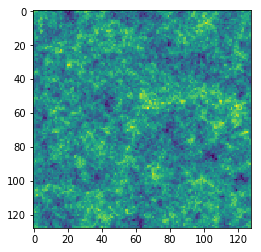

In [55]:
resolution = 128
linear_field = apply_powerlaw_power_spectrum(whitenoise(resolution))
plt.figure()
plt.imshow(linear_field)    


In [56]:
def get_potential_gradients(den_real):
    """Starting from a density field in 2D, get the potential gradients i.e.
    returns the two components of grad (grad^-2 den_real)"""
    den = np.fft.fft2(den_real)
    freqs = np.fft.fftfreq(den.shape[0])
    del_sq_operator = -(freqs[:,np.newaxis]**2+freqs[np.newaxis,:]**2)

    grad_x_operator = -1.j*np.fft.fftfreq(den.shape[0])[:,np.newaxis]
    grad_y_operator = -1.j*np.fft.fftfreq(den.shape[0])[np.newaxis,:]

    phi = den/del_sq_operator
    removeNaN(phi)

    grad_phi_x = grad_x_operator*phi
    grad_phi_y = grad_y_operator*phi

    grad_phi_x_real = np.fft.ifft2(grad_phi_x).real
    grad_phi_y_real = np.fft.ifft2(grad_phi_y).real

    return grad_phi_x_real, grad_phi_y_real



def get_potential_gradients3d(den_real):
    """Starting from a density field in 2D, get the potential gradients i.e.
    returns the two components of grad (grad^-2 den_real)"""
    den = np.fft.fftn(den_real)
    freqs = np.fft.fftfreq(den.shape[0])
    del_sq_operator = -(freqs[:,np.newaxis,np.newaxis]**2+freqs[np.newaxis,:,np.newaxis]**2+freqs[np.newaxis,np.newaxis,:]**2)

    grad_x_operator = -1.j*np.fft.fftfreq(den.shape[0])[:,np.newaxis,np.newaxis]
    grad_y_operator = -1.j*np.fft.fftfreq(den.shape[0])[np.newaxis,:,np.newaxis]
    grad_z_operator = -1.j*np.fft.fftfreq(den.shape[0])[np.newaxis,np.newaxis,:]
    phi = den/del_sq_operator
    removeNaN(phi)
    
    grad_phi_x = grad_x_operator*phi
    grad_phi_y = grad_y_operator*phi
    grad_phi_z = grad_z_operator*phi
    
    grad_phi_x_real = np.fft.ifftn(grad_phi_x).real
    grad_phi_y_real = np.fft.ifftn(grad_phi_y).real
    grad_phi_z_real = np.fft.ifftn(grad_phi_z).real
    
    return grad_phi_x_real, grad_phi_y_real, grad_phi_z_real

In [57]:
def evolved_particle_positions(den, time):
    """Generate a grid of particles, one for each cell of the density field,
    then displace those particles along gradient of potential implied by
    the density field."""
    N = resolution
    x,y = np.mgrid[0.:N,0.:N]
    grad_x, grad_y = get_potential_gradients(den)
    x+=time*grad_x
    y+=time*grad_y   
    while( (np.amax(x)>N) | (np.amax(y)>N) | (np.amin(x)<0) | (np.amin(y)<0) ):
      x[x>N]-=N
      y[y>N]-=N
      x[x<0]+=N
      y[y<0]+=N
    return x.flatten(),y.flatten()


def evolved_particle_positions_nonflat(den, time):
    """Generate a grid of particles, one for each cell of the density field,
    then displace those particles along gradient of potential implied by
    the density field."""
    N = resolution
    x,y = np.mgrid[0.:N,0.:N]
    grad_x, grad_y = get_potential_gradients(den)
    x+=time*grad_x
    y+=time*grad_y
    
    
    while( (np.amax(x)>N) | (np.amax(y)>N) | (np.amin(x)<0) | (np.amin(y)<0) ):
      x[x>N]-=N
      y[y>N]-=N
      x[x<0]+=N
      y[y<0]+=N
    return x,y




def evolved_particle_positions3d(den, time=0.025):
    """Generate a grid of particles, one for each cell of the density field,
    then displace those particles along gradient of potential implied by
    the density field."""
    N = len(den)
    x,y,z = np.mgrid[0.:N,0.:N,0.:N]
    grad_x, grad_y, grad_z = get_potential_gradients3d(den)
    
    x+=time*grad_x
    y+=time*grad_y
    z+=time*grad_z
    
    
    
    x[x>N]-=N
    y[y>N]-=N
    z[z>N]-=N
    
    x[x<0]+=N
    y[y<0]+=N
    z[z<0]+=N
    
    
    
    
    
    return x.flatten(),y.flatten(),z.flatten()

In [58]:
def densityCIC(x,y):   #  0 <  x, y, z < nGr in 1D 
    #x = (x-x_l)*Nx/(x_h - x_l)
    #y = (y-y_l)*Ny/(y_h - y_l) 
    Np = np.size(x)
    #nGrid = Np
    macro = np.zeros([nGrid, nGrid])
    
    for particle in range(Np):
        i = int(x[particle]) 
        j = int(y[particle]) 
        dx = dy = 1
        
        a1 = np.around(x[particle], decimals = 4) - i*dx
        b1 = np.around(y[particle], decimals = 4) - j*dy   
        
        wx1 = a1/dx
        wx2 = (dx - a1)/dx
        wy1 = b1/dy
        wy2 = (dy - b1)/dy        
        
        macro[i, j] += (wx1 * wy1)
        macro[np.mod(i+1,nGrid), j] += (wx2 * wy1)
        macro[i, np.mod(j+1,nGrid)] += (wx1 * wy2)
        macro[np.mod(i+1,nGrid), np.mod(j+1,nGrid)] += (wx2 * wy2 )
    return macro


def densityCIC3d(x,y,z):   #  0 <  x, y, z < nGr in 1D 
    #x = (x-x_l)*Nx/(x_h - x_l)
    #y = (y-y_l)*Ny/(y_h - y_l) 
    Np = np.size(x)
    macro = np.zeros([nGrid, nGrid, nGrid])
    for particle in range(Np):
        i = int(x[particle]) 
        j = int(y[particle]) 
        k = int(z[particle])
        
        dx = dy = dz = 1
        
        a1 = np.around(x[particle], decimals = 4) - i*dx
        b1 = np.around(y[particle], decimals = 4) - j*dy   
        c1 = np.around(z[particle], decimals = 4) - k*dz
        
        wx1 = a1/dx
        wx2 = (dx - a1)/dx
        
        
        wy1 = b1/dy
        wy2 = (dy - b1)/dy        
        
        
        wz1 = c1/dz
        wz2 = (dz - c1)/cy
        
        
        
        macro[i, j, k] += (wx1 * wy1 * wz1)
        
        macro[np.mod(i+1,nGrid), j, k ] +=(wx2 * wy1 * wz1)
        
        macro[i, np.mod(j+1,nGrid), k] += (wx1 * wy2 * wx1)
        
        macro[i, j , np.mod(k+1,nGrid)] += (wx1 * wy1* wz2)
        
        macro[np.mod(i+1,nGrid), np.mod(j+1,nGrid), k] += (wx2 * wy2 * wz1)
        
        macro[np.mod(i+1,nGrid), j, np.mod(k+1,nGrid)] += (wx2 * wy1 * wz2)
        
        macro[i, np.mod(j+1,nGrid), np.mod(k+1,nGrid)] += (wx1 * wy2 * wz2)
        
        macro[np.mod(i+1,nGrid), np.mod(j+1,nGrid), np.mod(k+1,nGrid)] += (wx2 * wy2 * wz2)
        
        
        
      #  macro[np.mod(i+1,nGrid), j] += (wx2 * wy1)
      #  macro[i, np.mod(j+1,nGrid)] += (wx1 * wy2)
      #  macro[np.mod(i+1,nGrid), np.mod(j+1,nGrid)] += (wx2 * wy2 )
    return macro

[0.001      0.00154445 0.00238533 0.00368403 0.00568981 0.00878764
 0.01357209 0.02096144 0.03237394 0.05      ]


/Users/dongxiaofeng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in reciprocal
  import sys


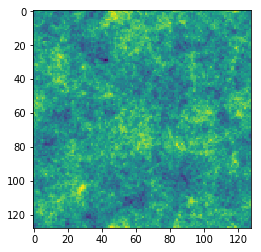

In [59]:
resolution = 128
nGrid = resolution
num_samples = 5

#a = np.logspace(np.log10(1),np.log10(0.1),10)
#print(a)

times=np.logspace(np.log10(0.001),np.log10(0.05),10)
print(times)




linear_field = apply_powerlaw_power_spectrum(whitenoise(resolution))
plt.imshow(linear_field)   
np.save("initial",linear_field)


[0.0001     0.00897778 0.01785556 0.02673333 0.03561111 0.04448889
 0.05336667 0.06224444 0.07112222 0.08      ]


/Users/dongxiaofeng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in reciprocal
  import sys
/Users/dongxiaofeng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/dongxiaofeng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


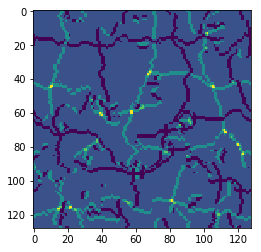

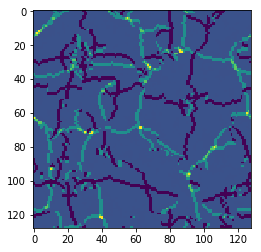

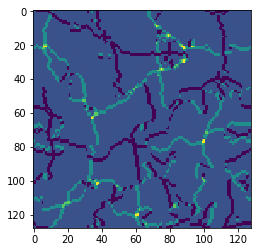

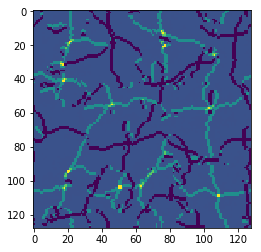

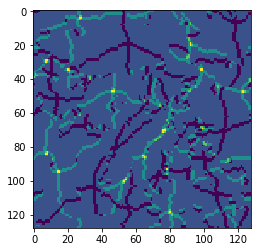

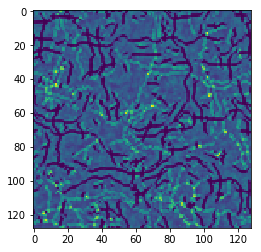

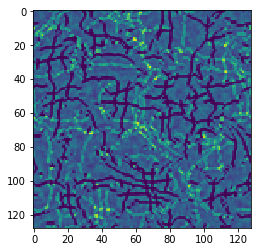

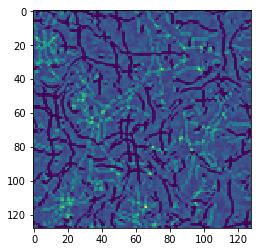

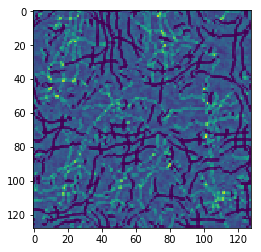

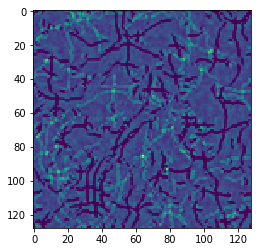

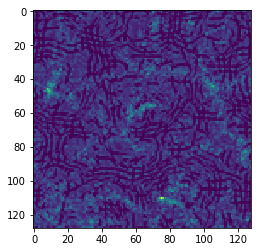

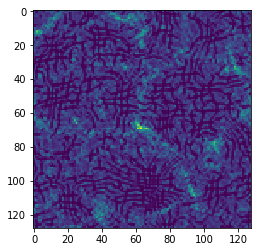

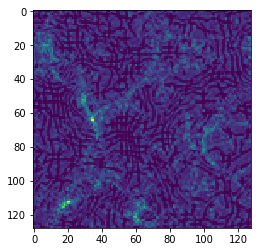

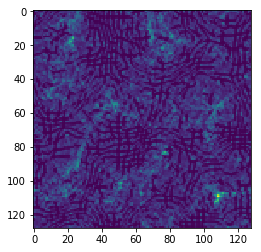

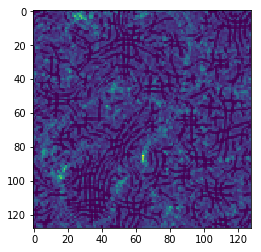

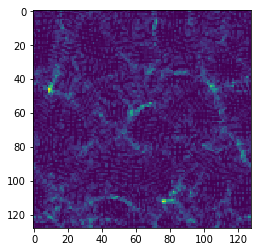

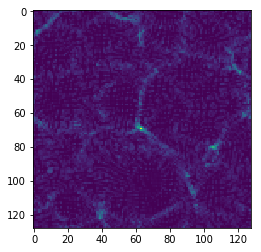

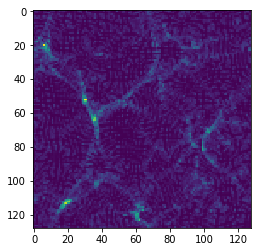

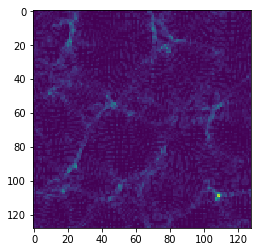

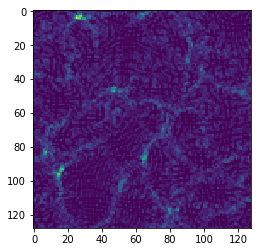

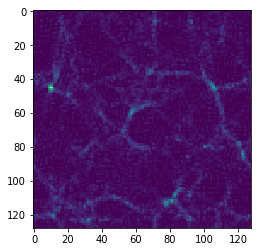

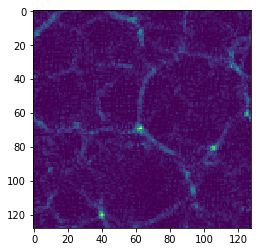

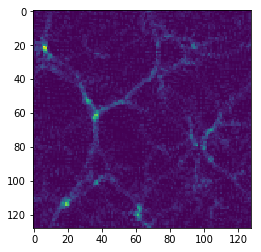

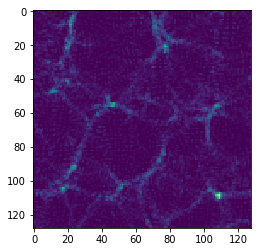

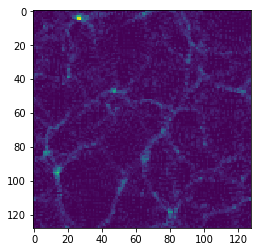

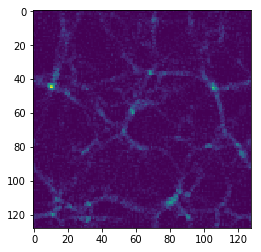

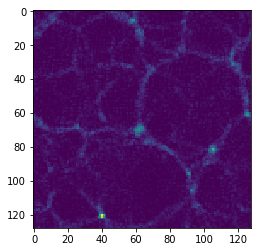

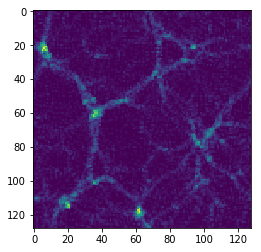

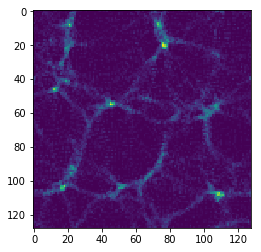

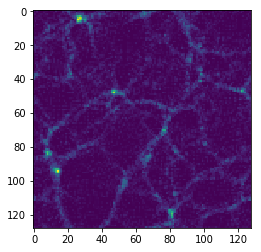

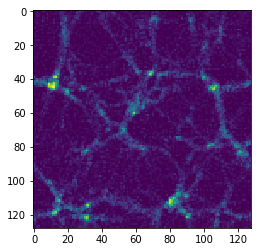

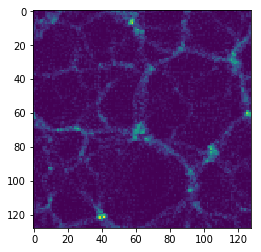

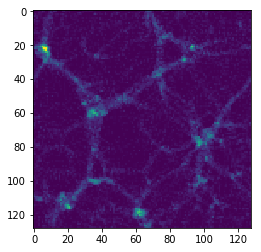

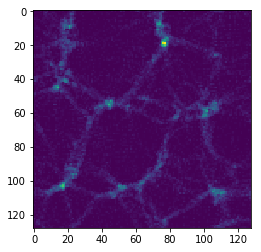

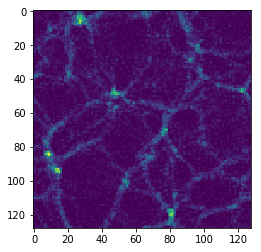

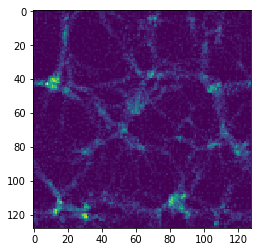

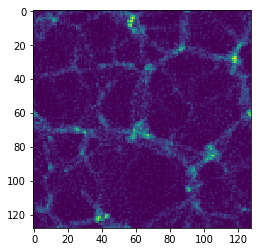

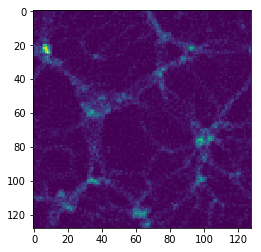

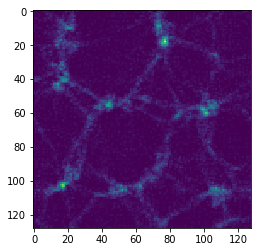

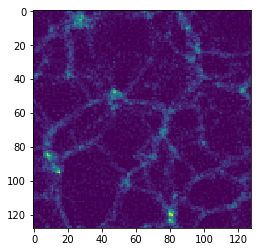

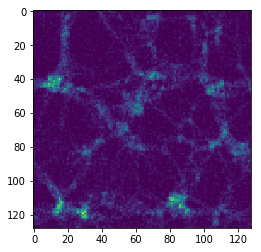

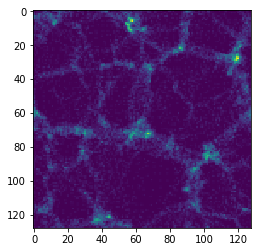

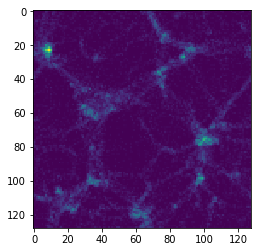

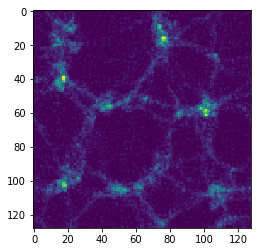

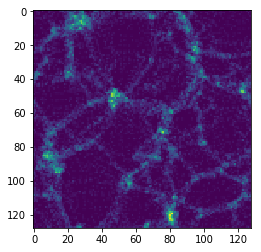

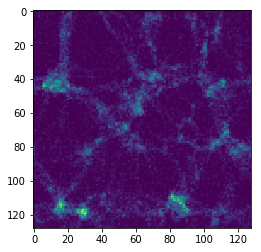

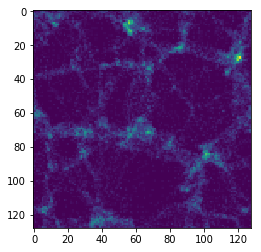

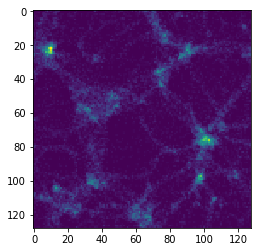

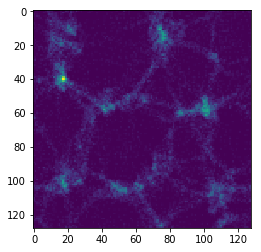

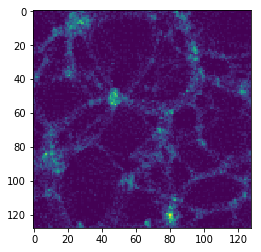

In [72]:
resolution = 128
nGrid = resolution
num_samples = 5

#a = np.logspace(np.log10(1),np.log10(0.1),10)
#print(a)

#times=np.logspace(np.log10(0.0001),np.log10(0.08),10)
times=np.linspace(0.0001,0.08,10)
print(times)

#### [times] array is the series of times that we generate snapshots. Simply change it and range of j correspondingly.


linear_field = apply_powerlaw_power_spectrum(whitenoise(resolution))
#pl    

#times = 1/(1+a)
#print(times)


for j in range(10):
  datamatrix = np.zeros((num_samples,resolution,resolution))  
  for i in range(num_samples):
    np.random.seed(i)
    
    linear_field = apply_powerlaw_power_spectrum(whitenoise(resolution))
    
    #plt.imshow(linear_field)
    
    
    #x0, y0 = evolved_particle_positions_nonflat(linear_field, time=t0)
    #x00,y00= evolved_particle_positions_nonflat(linear_field, time=t0)
    x1, y1 = evolved_particle_positions_nonflat(linear_field, time=times[j])
    
    #print(np.amax(y1))

    x11,y11= evolved_particle_positions(linear_field, time=times[j])
    datamatrix[i] = densityCIC(x11,y11)
    plt.figure()
    plt.imshow(datamatrix[i])
    #fig = plt.figure(frameon=False)
    #ax = plt.Axes(fig, [0., 0., 1., 1.])
    #fig.set_size_inches(6,6)
    #ax.set_axis_off()
    #fig.add_axes(ax)
    #ax.scatter(x1, y1, s=0.001, label = 'Time' + str(t1))
    #plt.show()
    #redshift = 
  np.save('num_'+str(j),datamatrix)  

# Useful code ends here. Following is about generating the movie.

In [ ]:
##### Next part is generating the movie #######

In [161]:
from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy
from moviepy.editor import VideoClip


IndexError: index 64 is out of bounds for axis 1 with size 64

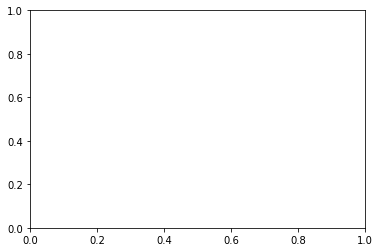

In [162]:


np.random.seed(1)
times= np.linspace(0.0001,1,100)
#for i in range(100):
#    np.random.seed(i)
    
linear_field = apply_powerlaw_power_spectrum(whitenoise(resolution))
    
duration=100
fig, ax= plt.subplots()
def make_frame(t):
    ax.clear()
    x11,y11= evolved_particle_positions(linear_field, time=t*0.01)
    datamatrix = densityCIC(x11,y11)
    ax.imshow(datamatrix)
    #plt.imshow(linear_field)
    return mplfig_to_npimage(fig)
    
animation = VideoClip(make_frame, duration=duration)
animation.write_gif('testing='+ str(i) + '.gif', fps=1)
        
    #x0, y0 = evolved_particle_positions_nonflat(linear_field, time=t0)
    #x00,y00= evolved_particle_positions_nonflat(linear_field, time=t0)
#    x1, y1 = evolved_particle_positions_nonflat(linear_field, time=times[j])
    
    #print(np.amax(y1))


    #fig = plt.figure(frameon=False)
    #ax = plt.Axes(fig, [0., 0., 1., 1.])
    #fig.set_size_inches(6,6)
    #ax.set_axis_off()
    #fig.add_axes(ax)
    #ax.scatter(x1, y1, s=0.001, label = 'Time' + str(t1))
    #plt.show()
    #redshift = 

/Users/dongxiaofeng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


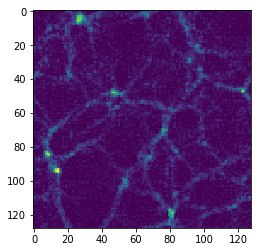

In [20]:
swe_data = np.log10(np.load("./0.05.npy"))
data = np.load("./0.05.npy")


In [40]:
for i in range(data.shape[0]):
    data[i]=data[i]+0.000001



In [41]:
np.min(data)

1e-06

0.0


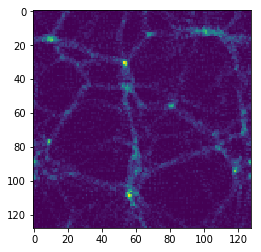

In [25]:

plt.figure()
plt.imshow(data[8000])

In [11]:
np.isinf(swe_data)

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [ True, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True, False, False, ...,  True,  True,  True],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal